# Plan
* Munge Ian's tables and match to files (done)
* Read in orders (done)
* Doppler correct everything (done with Ian's data)
* Rebin flux and weights to common dispersion map
    * Identify individual orders
    * Interpolate each order to a common map after RV
    * Make all observations have the same wavelength range by cutting off pixels
* Normalize
    * Identify best continuum regions for each order
        * By hand?
        * The Cannon, with small labels?
    * Fit continuum to only those wavelengths/pixels


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from smh import specutils; reload(specutils)
from smh.specutils import Spectrum1D, motions
from astropy.io import ascii, fits
from astropy import table
import glob, os, sys, time, re
import pandas as pd
from collections import OrderedDict
from scipy import optimize, interpolate
from astropy.time import Time

# Munge big table
* map files to entries in table
* map abundances

In [3]:
def month2month(monthstr):
    data = {"Jan":1,"Feb":2,"Mar":3,"Apr":4,"May":5,"Jun":6,
            "Jul":7,"Aug":8,"Sep":9,"Oct":10,"Nov":11,"Dec":12}
    return "{:02}".format(data[monthstr])

In [4]:
tab = ascii.read("tab02.tex", delimiter='&',guess=False,comment="%")
instruments = map(lambda x: x.split("/")[1], tab["Telescope/Instrument"])
years = map(lambda x: x.split()[0], tab["Date"])
months = map(lambda x: month2month(x.split()[1]), tab["Date"])
days = map(lambda x: x.split()[2], tab["Date"])
tab.add_column(table.Column(instruments, name="Instrument"))
tab.add_column(table.Column(years, name="Year"))
tab.add_column(table.Column(months, name="Month"))
tab.add_column(table.Column(days, name="Day"))


In [5]:
tab.show_in_notebook()

GWP = George Preston (Blue)

IBT = Ian Thompson (Green)

IUR = Ian Roederer (Red)

SAS = Steve Shectman (Cyan)

In [6]:
for observer in np.unique(tab["Observer"]):
    print observer, np.sum(tab["Observer"]==observer), np.sum(tab[tab["Observer"]==observer]["ExpTime"])/3600.

GWP 65 53.3152777778
IBT 35 12.1961111111
IUR 21 16.3388888889
SAS 17 15.2222222222


In [7]:
dates_by_observer = [tab[ii]["MJD"] for ii in [tab["Observer"]==observer for observer in ["GWP","IBT","IUR","SAS"]]]

([array([ 16.,   5.,   1.,  18.,  12.,   7.,   6.,   0.,   0.,   0.]),
  array([ 18.,  16.,   4.,  19.,  12.,  10.,  21.,   0.,   0.,   0.]),
  array([ 18.,  16.,   4.,  19.,  12.,  10.,  21.,   3.,   0.,  18.]),
  array([ 33.,  16.,   4.,  19.,  12.,  10.,  21.,   5.,   0.,  18.])],
 array([ 2452653.79  ,  2453028.9998,  2453404.2096,  2453779.4194,
         2454154.6292,  2454529.839 ,  2454905.0488,  2455280.2586,
         2455655.4684,  2456030.6782,  2456405.888 ]),
 <a list of 4 Lists of Patches objects>)

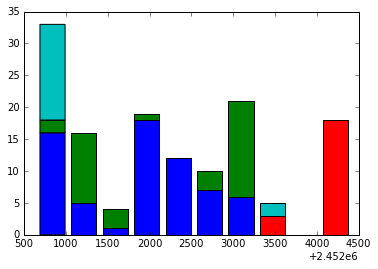

In [8]:
plt.figure()
plt.hist(dates_by_observer, stacked=True)

Nice this is all done over 11 years...

Manual name check to ensure everything is there. I had to manually change two stars that had typos.

In [9]:
fnames = map(os.path.basename, glob.glob("data/*.fits"))
def get_goodname(name):
    if name.startswith("bdm"):
        name = "_".join(name.split("-"))
        name = "bd-"+name[3:]
    if name.startswith("bdp"):
        name = "_".join(name.split("-"))
        name = "bd+"+name[3:]
    if name.startswith("cdm"):
        name = "_".join(name.split("-"))
        name = "cd-"+name[3:]
    if name.startswith("cdp"):
        name = "_".join(name.split("-"))
        name = "cd+"+name[3:]
    if "blue" in name:
        return name.split("blue")[0].upper()
    if "red" in name:
        return name.split("red")[0].upper()
goodnames = map(get_goodname, fnames)
for name in goodnames:
    if name not in tab["Star"]: print name
print
for name in tab["Star"]:
    if name not in goodnames: print name

In [10]:
tab.colnames

['Star',
 'Telescope/Instrument',
 'Observer',
 'ExpTime',
 'Date',
 'UT',
 'MJD',
 'vhel',
 'Instrument',
 'Year',
 'Month',
 'Day']

In [11]:
# for each file, find its row
from datetime import datetime
def calc_mjd(fname):
    with fits.open(fname) as hdulist:
        header = hdulist[0].header
        ut_date = header["UT-DATE"]
        ut_time = header["UT-TIME"] # time in seconds
    for sep in ["-","/"]:
        try:
            year, month, day = ut_date.split(sep)
        except:
            pass
        else:
            year = int(year); month = int(month); day = int(day)
            break
    hour = int(ut_time/3600.)
    minute = int((ut_time - 3600*hour)/60.)
    second = int((ut_time - 3600*hour - 60*minute)/60.)
    try:
        t = Time(datetime(year, month, day, hour, minute, second), scale='utc')
    except:
        print ut_date, ut_time
        print year, month, day
        print hour, minute, second
        raise
    return t.jd
def find_row(fname, tab):
    fname = os.path.basename(fname)
    goodname = get_goodname(fname)
    name, other = fname.split("_multi_")
    assert other.endswith(".fits")
    year = other[0:4]
    month = other[4:6]
    observer = other[6:9]
    if other[9]=="-":
        number = other[10]
    else:
        number = "1"
    ii = np.array(goodname == tab["Star"]) & np.array(year == tab["Year"]) & np.array(month == tab["Month"])
    assert np.sum(ii) > 0, fname
    if np.sum(ii) != 1:
        mjd = calc_mjd("data/"+fname)
        subtab = tab[ii]
        ix = np.argmin(np.abs(subtab["MJD"] - mjd))
        day = subtab[ix]["Day"]
        ii = np.array(goodname == tab["Star"]) & np.array(year == tab["Year"]) & np.array(month == tab["Month"]) \
              & np.array(day == tab["Day"])
        assert np.sum(ii) == 1, fname
        ix = np.where(ii)[0][0]
        #print "MULTIPLE:",mjd, fname,np.sum(ii), ix, list(tab[ii]["MJD"]) #np.min(np.abs(tab["MJD"]-mjd))
    return np.where(ii)[0][0]
all_fnames_blue = []
all_out_blue = []
all_fnames_red = []
all_out_red = []
for fname in fnames:
    out = find_row(fname, tab)
    if "blue" in fname:
        all_fnames_blue.append(fname)
        all_out_blue.append(out)
    else:
        all_fnames_red.append(fname)
        all_out_red.append(out)
all_fnames_blue = np.array(all_fnames_blue)
all_fnames_red = np.array(all_fnames_red)
assert np.all(np.array(all_out_blue) == np.array(all_out_red))
ii = np.argsort(all_out_blue)


In [12]:
print len(all_out_blue), len(np.unique(all_out_blue)), len(fnames)/2, len(tab)

138 138 138 138


In [13]:
tab.add_column(tab.Column(all_fnames_blue[ii],"blue_fname"))
tab.add_column(tab.Column(all_fnames_red[ii], "red_fname"))

In [14]:
labels = ascii.read("fe2.dat", names=["Star","class","Teff","ulflag","logeps","[X/Fe]","e_sta","e_tot","e_I","e_II","[Fe/H]"])

Note that [X/Fe] here is the same as [Fe/H] (it is all Fe II)

In [15]:
for name in labels["Star"]:
    if name not in tab["Star"]: print name
print
for name in tab["Star"]:
    if name not in labels["Star"]: print name

In [16]:
df1 = tab.to_pandas()
df2 = labels.to_pandas()
df1.index = df1["Star"]
df2.index = df2["Star"]

In [17]:
print len(df1), len(df2), len(fnames)/2.
print len(np.unique(df1["Star"])), len(np.unique(df2["Star"]))

138 92 138.0
92 92


So there are 138-92=46 repeated observations of the same stars.

# Read spectra

In [18]:
def read_multispec(fname, full_output=False):
    """
    There are some files that are not reduced with Dan Kelson's current pipeline version.
    So we have to read those manually and define ivar
    """
    # Hardcoded file with old CarPy format: 5 bands instead of 7
    if "hd13979red_multi_200311ibt" in fname:
        WAT_LENGTH=67
    else:
        WAT_LENGTH=68
    
    #try:
    #    orders = Spectrum1D.read(fname, WAT_LENGTH=WAT_LENGTH)
    #    code = 1
    #except:
    # This is the old format: (Norders x Npix) with no noise spec...
    with fits.open(fname) as hdulist:
        assert len(hdulist)==1, len(hdulist)
        header = hdulist[0].header
        data = hdulist[0].data
        # orders x pixels
        # assert len(data.shape)==2, data.shape

        metadata = OrderedDict()
        for k, v in header.items():
            if k in metadata:
                metadata[k] += v
            else:
                metadata[k] = v

    ## Compute dispersion
    assert metadata["CTYPE1"].upper().startswith("MULTISPE") \
        or metadata["WAT0_001"].lower() == "system=multispec"
    # Join the WAT keywords for dispersion mapping.
    i, concatenated_wat, key_fmt = (1, str(""), "WAT2_{0:03d}")
    while key_fmt.format(i) in metadata:
        value = metadata[key_fmt.format(i)]
        concatenated_wat += value + (" "  * (WAT_LENGTH - len(value)))
        i += 1
    # Split the concatenated header into individual orders.
    order_mapping = np.array([map(float, each.rstrip('" ').split()) \
        for each in re.split('spec[0-9]+ ?= ?"', concatenated_wat)[1:]])
    dispersion = np.array(
        [specutils.spectrum.compute_dispersion(*mapping) for 
         mapping in order_mapping])
    
    if len(data.shape)==2:
        ## Compute flux
        flux = data
        flux[0 > flux] = np.nan

        ## Compute ivar assuming Poisson noise
        ivar = 1./flux
        ivar[0 > flux] = 0
        code=1
    elif len(data.shape)==3:
        flux = data[1]
        ivar = data[2]**(-2)
        flux[0 > flux] = np.nan
        ivar[0 > flux] = 0
        code=2

    ## Turn into orders
    orders = [Spectrum1D(dispersion=d, flux=f, ivar=i, metadata=metadata.copy()) \
              for d,f,i in zip(dispersion, flux, ivar)]
    for order, mapping in zip(orders, order_mapping):
        order.metadata["aperture"] = mapping[0]
        order.metadata["beam"] = mapping[1]
    if full_output: return orders, code
    return orders

"""
def read_multispec(fname, full_output=False):
    
    "There are some files that are not reduced with Dan Kelson's pipeline.
    So we have to read those manually and define ivar
    "
    # Hardcoded file with old CarPy format: 5 bands instead of 7
    if "hd13979red_multi_200311ibt" in fname:
        WAT_LENGTH=67
    else:
        WAT_LENGTH=68
    
    try:
        orders = Spectrum1D.read(fname, WAT_LENGTH=WAT_LENGTH)
        code = 1
    except:
        # This is the old format: (Norders x Npix) with no noise spec...
        with fits.open(fname) as hdulist:
            assert len(hdulist)==1, len(hdulist)
            header = hdulist[0].header
            data = hdulist[0].data
            # orders x pixels
            assert len(data.shape)==2, data.shape
            
            metadata = OrderedDict()
            for k, v in header.items():
                if k in metadata:
                    metadata[k] += v
                else:
                    metadata[k] = v
        
        ## Compute dispersion
        assert metadata["CTYPE1"].upper().startswith("MULTISPE") \
            or metadata["WAT0_001"].lower() == "system=multispec"
        # Join the WAT keywords for dispersion mapping.
        i, concatenated_wat, key_fmt = (1, str(""), "WAT2_{0:03d}")
        while key_fmt.format(i) in metadata:
            value = metadata[key_fmt.format(i)]
            concatenated_wat += value + (" "  * (WAT_LENGTH - len(value)))
            i += 1
        # Split the concatenated header into individual orders.
        order_mapping = np.array([map(float, each.rstrip('" ').split()) \
            for each in re.split('spec[0-9]+ ?= ?"', concatenated_wat)[1:]])
        dispersion = np.array(
            [specutils.spectrum.compute_dispersion(*mapping) for 
             mapping in order_mapping])
        
        ## Compute flux
        flux = data
        flux[0 > flux] = np.nan
        
        ## Compute ivar assuming Poisson noise
        ivar = 1./flux
        
        ## Turn into orders
        orders = [Spectrum1D(dispersion=d, flux=f, ivar=i, metadata=metadata) \
                  for d,f,i in zip(dispersion, flux, ivar)]
        code = 2
    if full_output: return orders, code
    return orders
""";

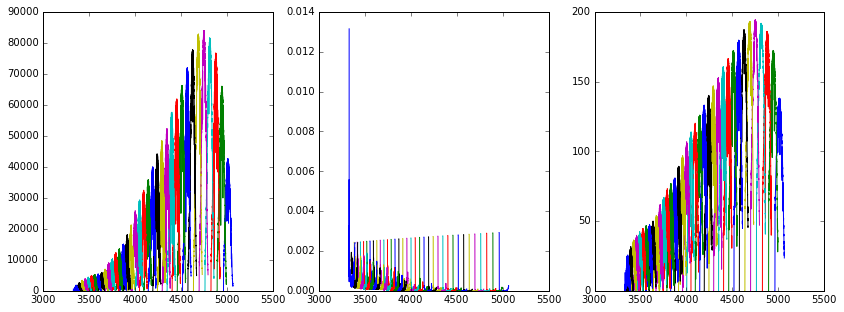

In [19]:
orders = read_multispec("data/bdm15-5781blue_multi_200910ibt.fits")
fig, axes = plt.subplots(1,3, figsize=(14,5))
for spec in orders:
    axes[0].plot(spec.dispersion, spec.flux)
    axes[1].plot(spec.dispersion, spec.ivar)
    axes[2].plot(spec.dispersion, spec.flux*np.sqrt(spec.ivar))
    

/Users/alexji/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/alexji/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/alexji/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/alexji/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/alexji/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/alexji/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/alexji/anaconda/lib/python2

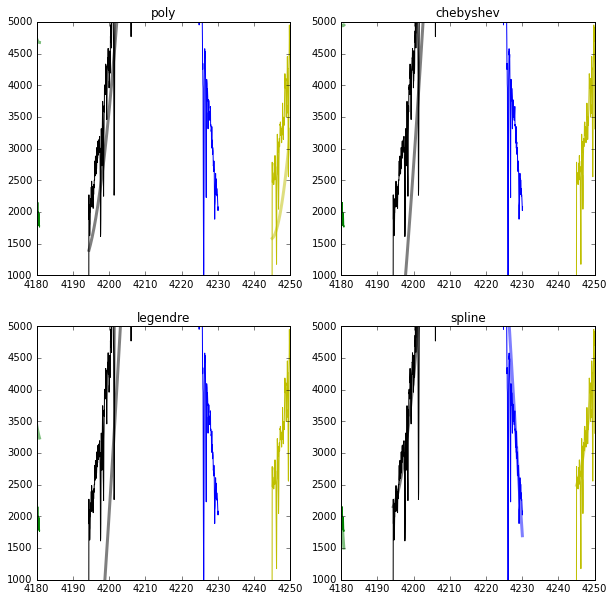

In [20]:
xmin, xmax = 4180, 4250
ymin, ymax = 1000, 5000
fig, axes = plt.subplots(2,2, figsize=(10,10))

all_conts = []
for ax, function, fitorder in zip(axes.flat, 
                               ["poly", "chebyshev", "legendre", "spline"],
                               [9, 9, 9, 3]):
    conts = []
    for order in orders:
        norm, cont, left, right = order.fit_continuum(function=function, full_output=True,
                                                      order=fitorder, knot_spacing=50,
                                                      low_sigma_clip=1.0, high_sigma_clip=0.2)
        l, = ax.plot(order.dispersion, order.flux)
        ax.plot(order.dispersion, cont, color=l.get_color(), lw=3, alpha=.5)
        conts.append(cont)
    all_conts.append(conts)
    ax.set_title(function)

for ax in axes.flat:
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)


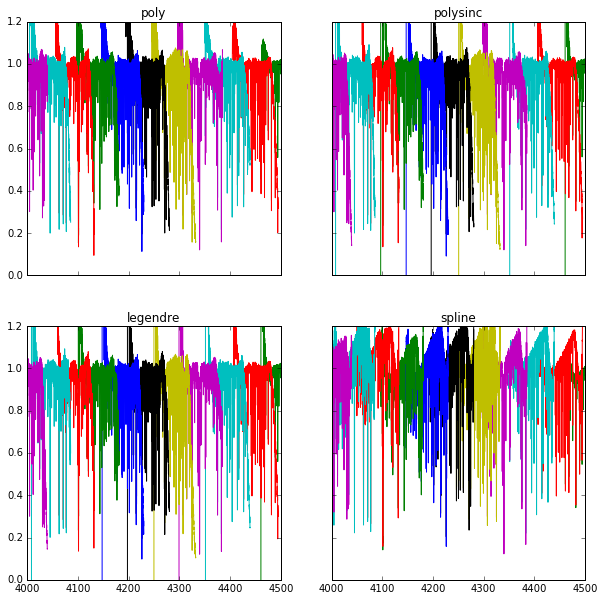

In [21]:
fig, axes = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)
for ax, func, conts in zip(axes.flat, ["poly", "polysinc", "legendre", "spline"], all_conts):
    for order, cont in zip(orders, conts):
        ax.plot(order.dispersion, order.flux/cont)
    ax.set_ylim(0,1.2)
    ax.set_xlim(4000,4500)
    ax.set_title(func)

# Radial Velocity Correct everything
Best to do it automatically ourselves, or to use Ian's velocities?

We'll use Ian's velocities and uncorrect the heliocentric correction to see if it's okay. Yes it is!

In [22]:
for col in ["vobs", "blue_wlmin", "blue_wlmax", "red_wlmin", "red_wlmax", "blue_norder", "red_norder", 
            "blue_wlmin2", "blue_wlmax2", "red_wlmin2", "red_wlmax2", "blue_norder2", "red_norder2",
            "order_nums","beam_nums","aper_nums"]:
    try:
        tab.remove_column(col)
    except:
        pass
all_rv_spec = []
vobss = []
blue_min = []; blue_max = []
red_min = []; red_max = []
blue_norder = []; red_norder = []
blue_min2 = []; blue_max2 = []
red_min2 = []; red_max2 = []
blue_norder2 = []; red_norder2 = []
order_numss = []; order_numss2 = []
for row in tab:
    print row["blue_fname"], row["red_fname"]
    ordernumkey = None
    
    blue = read_multispec("data/{}".format(row["blue_fname"]))
    if blue[0].dispersion[0] > blue[-1].dispersion[0]:
        blue = blue[::-1]
    red  = read_multispec("data/{}".format(row["red_fname"]))
    if red[0].dispersion[0] > red[-1].dispersion[0]:
        red = red[::-1]
    vbar, vhel = motions.corrections_from_headers(blue[0].metadata)
    if row["vhel"]=="\\nodata":
        #vobss.append(np.nan)
        assert row["Star"]=="CS22940-077"
        vobs = +0.9
        vobss.append(+0.9) #manually did this in SMHr against HD140283
    else:
        vobs = float(row["vhel"]) - vhel.to('km/s').value
        vobss.append(vobs)

    # Before RV correction (good for instrument matching)
    blue_min.append(blue[0].dispersion[0])
    blue_max.append(blue[-1].dispersion[-1])
    blue_norder.append(len(blue))
    red_min.append(red[0].dispersion[0])
    red_max.append(red[-1].dispersion[-1])
    red_norder.append(len(red))
    
    
    
    orders = blue+red
    vcorr = -vobs
    order_nums = []; order_nums2 = []
    for order in orders:
        order.redshift(vcorr)
        if ordernumkey is None:
            if int(order.metadata["beam"])==1:
                ordernumkey = "aperture"
            else:
                ordernumkey = "beam"
        #if row["blue_fname"] in ["cs22898-047blue_multi_200406gwp.fits", "cs22944-032blue_multi_200406gwp.fits"]:
        #    order_nums.append(str(int(order.metadata[ordernumkey])-1))
        #else:
        order_nums.append(str(int(order.metadata[ordernumkey])))

    all_rv_spec.append(orders)
    order_nums = ",".join(order_nums)
    order_numss.append(order_nums)
    
    # After RV correction
    blue_min2.append(blue[0].dispersion[0])
    blue_max2.append(blue[-1].dispersion[-1])
    blue_norder2.append(len(blue))
    red_min2.append(red[0].dispersion[0])
    red_max2.append(red[-1].dispersion[-1])
    red_norder2.append(len(red))
    
tab.add_column(tab.Column(vobss, "vobs"))
tab.add_column(tab.Column(blue_min, "blue_wlmin"))
tab.add_column(tab.Column(blue_max, "blue_wlmax"))
tab.add_column(tab.Column(red_min, "red_wlmin"))
tab.add_column(tab.Column(red_max, "red_wlmax"))
tab.add_column(tab.Column(blue_norder, "blue_norder"))
tab.add_column(tab.Column(red_norder, "red_norder"))
tab.add_column(tab.Column(blue_min2, "blue_wlmin2"))
tab.add_column(tab.Column(blue_max2, "blue_wlmax2"))
tab.add_column(tab.Column(red_min2, "red_wlmin2"))
tab.add_column(tab.Column(red_max2, "red_wlmax2"))
tab.add_column(tab.Column(blue_norder2, "blue_norder2"))
tab.add_column(tab.Column(red_norder2, "red_norder2"))
tab.add_column(tab.Column(order_numss, "order_nums"))

cs22166-016blue_multi_200408gwp.fits cs22166-016red_multi_200408gwp.fits
cs22169-035blue_multi_200301gwp-1.fits cs22169-035red_multi_200301gwp-1.fits
cs22169-035blue_multi_200301gwp-2.fits cs22169-035red_multi_200301gwp-2.fits
cs22169-035blue_multi_200708gwp.fits cs22169-035red_multi_200708gwp.fits
cs22172-029blue_multi_200809gwp-1.fits cs22172-029red_multi_200809gwp-1.fits
cs22172-029blue_multi_200809gwp-2.fits cs22172-029red_multi_200809gwp-2.fits
cs22183-031blue_multi_200608gwp.fits cs22183-031red_multi_200608gwp.fits
cs22185-007blue_multi_201208iur.fits cs22185-007red_multi_201208iur.fits
cs22186-023blue_multi_200301gwp.fits cs22186-023red_multi_200301gwp.fits
cs22186-023blue_multi_200508gwp.fits cs22186-023red_multi_200508gwp.fits
cs22189-009blue_multi_200409ibt.fits cs22189-009red_multi_200409ibt.fits
cs22873-128blue_multi_200608gwp.fits cs22873-128red_multi_200608gwp.fits
cs22877-001blue_multi_200301gwp-1.fits cs22877-001red_multi_200301gwp-1.fits
cs22877-001blue_multi_200301gwp

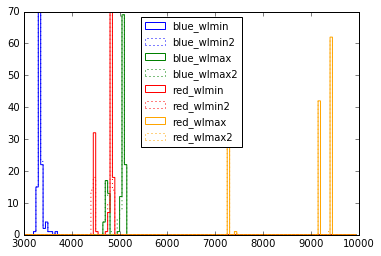

In [23]:
plt.figure()
colors = ['b','g','r','orange']
for i,col in enumerate(["blue_wlmin", "blue_wlmax", "red_wlmin", "red_wlmax"]):
    h, x, p = plt.hist(tab[col], label=col, histtype='step', color=colors[i], bins=np.arange(3000, 10000, 50))
    h, x, p = plt.hist(tab[col+"2"], label=col+"2", histtype='step', color=colors[i], linestyle=":", bins=np.arange(3000, 10000, 50))
#plt.hist(tab["blue_wlmin"], label="blue_wlmin", histtype='step')
#plt.hist(tab["blue_wlmax"], label="blue_wlmax", histtype='step')
#plt.hist(tab["red_wlmin"], label="red_wlmin", histtype='step')
#plt.hist(tab["red_wlmax"], label="red_wlmax", histtype='step')
plt.legend(loc='upper center', fontsize=10)


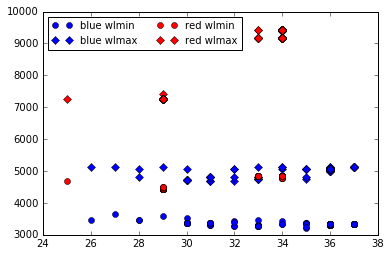

In [24]:
plt.figure()
plt.plot(tab["blue_norder"], tab["blue_wlmin"], 'bo', label="blue wlmin")
plt.plot(tab["blue_norder"], tab["blue_wlmax"], 'bD', label="blue wlmax")
plt.plot(tab["red_norder"], tab["red_wlmin"], 'ro', label="red wlmin")
plt.plot(tab["red_norder"], tab["red_wlmax"], 'rD', label="red wlmax")
plt.legend(loc='upper left', ncol=2, fontsize=10)

In [25]:
template = Spectrum1D.read("/Users/alexji/smhr/smh/data/spectra/hd122563.fits")

In [26]:
len(all_rv_spec)

138

This is one I fit manually in SMHr

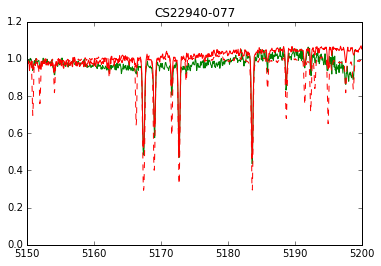

In [27]:
orders = all_rv_spec[38]
fig, ax = plt.subplots()
for order in orders:
    norm = order.fit_continuum(function="spline", full_output=False,
                               order=fitorder, knot_spacing=50,
                               low_sigma_clip=1.0, high_sigma_clip=0.2)
    ax.plot(norm.dispersion, norm.flux)
ax.set_ylim(0,1.2)
ax.set_xlim(5150,5200)
ax.plot(template.dispersion, template.flux, 'r--')
ax.set_title(tab[38]["Star"])
    

2018-04-01 11:59:22,084 [ERROR   ] Exception in fitting continuum:
Traceback (most recent call last):
  File "/Users/alexji/lib/smhr/smh/specutils/spectrum.py", line 902, in fit_continuum
    k=order, task=-1, t=knots, w=splrep_weights)
  File "/Users/alexji/anaconda/lib/python2.7/site-packages/scipy/interpolate/fitpack.py", line 278, in splrep
    res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
  File "/Users/alexji/anaconda/lib/python2.7/site-packages/scipy/interpolate/_fitpack_impl.py", line 515, in splrep
    raise _iermess[ier][1](_iermess[ier][0])
ValueError: Error on input data
2018-04-01 11:59:22,084 [ERROR   ] Exception in fitting continuum:
Traceback (most recent call last):
  File "/Users/alexji/lib/smhr/smh/specutils/spectrum.py", line 902, in fit_continuum
    k=order, task=-1, t=knots, w=splrep_weights)
  File "/Users/alexji/anaconda/lib/python2.7/site-packages/scipy/interpolate/fitpack.py", line 278, in splrep
    res = _impl.splrep(x, y, w, x

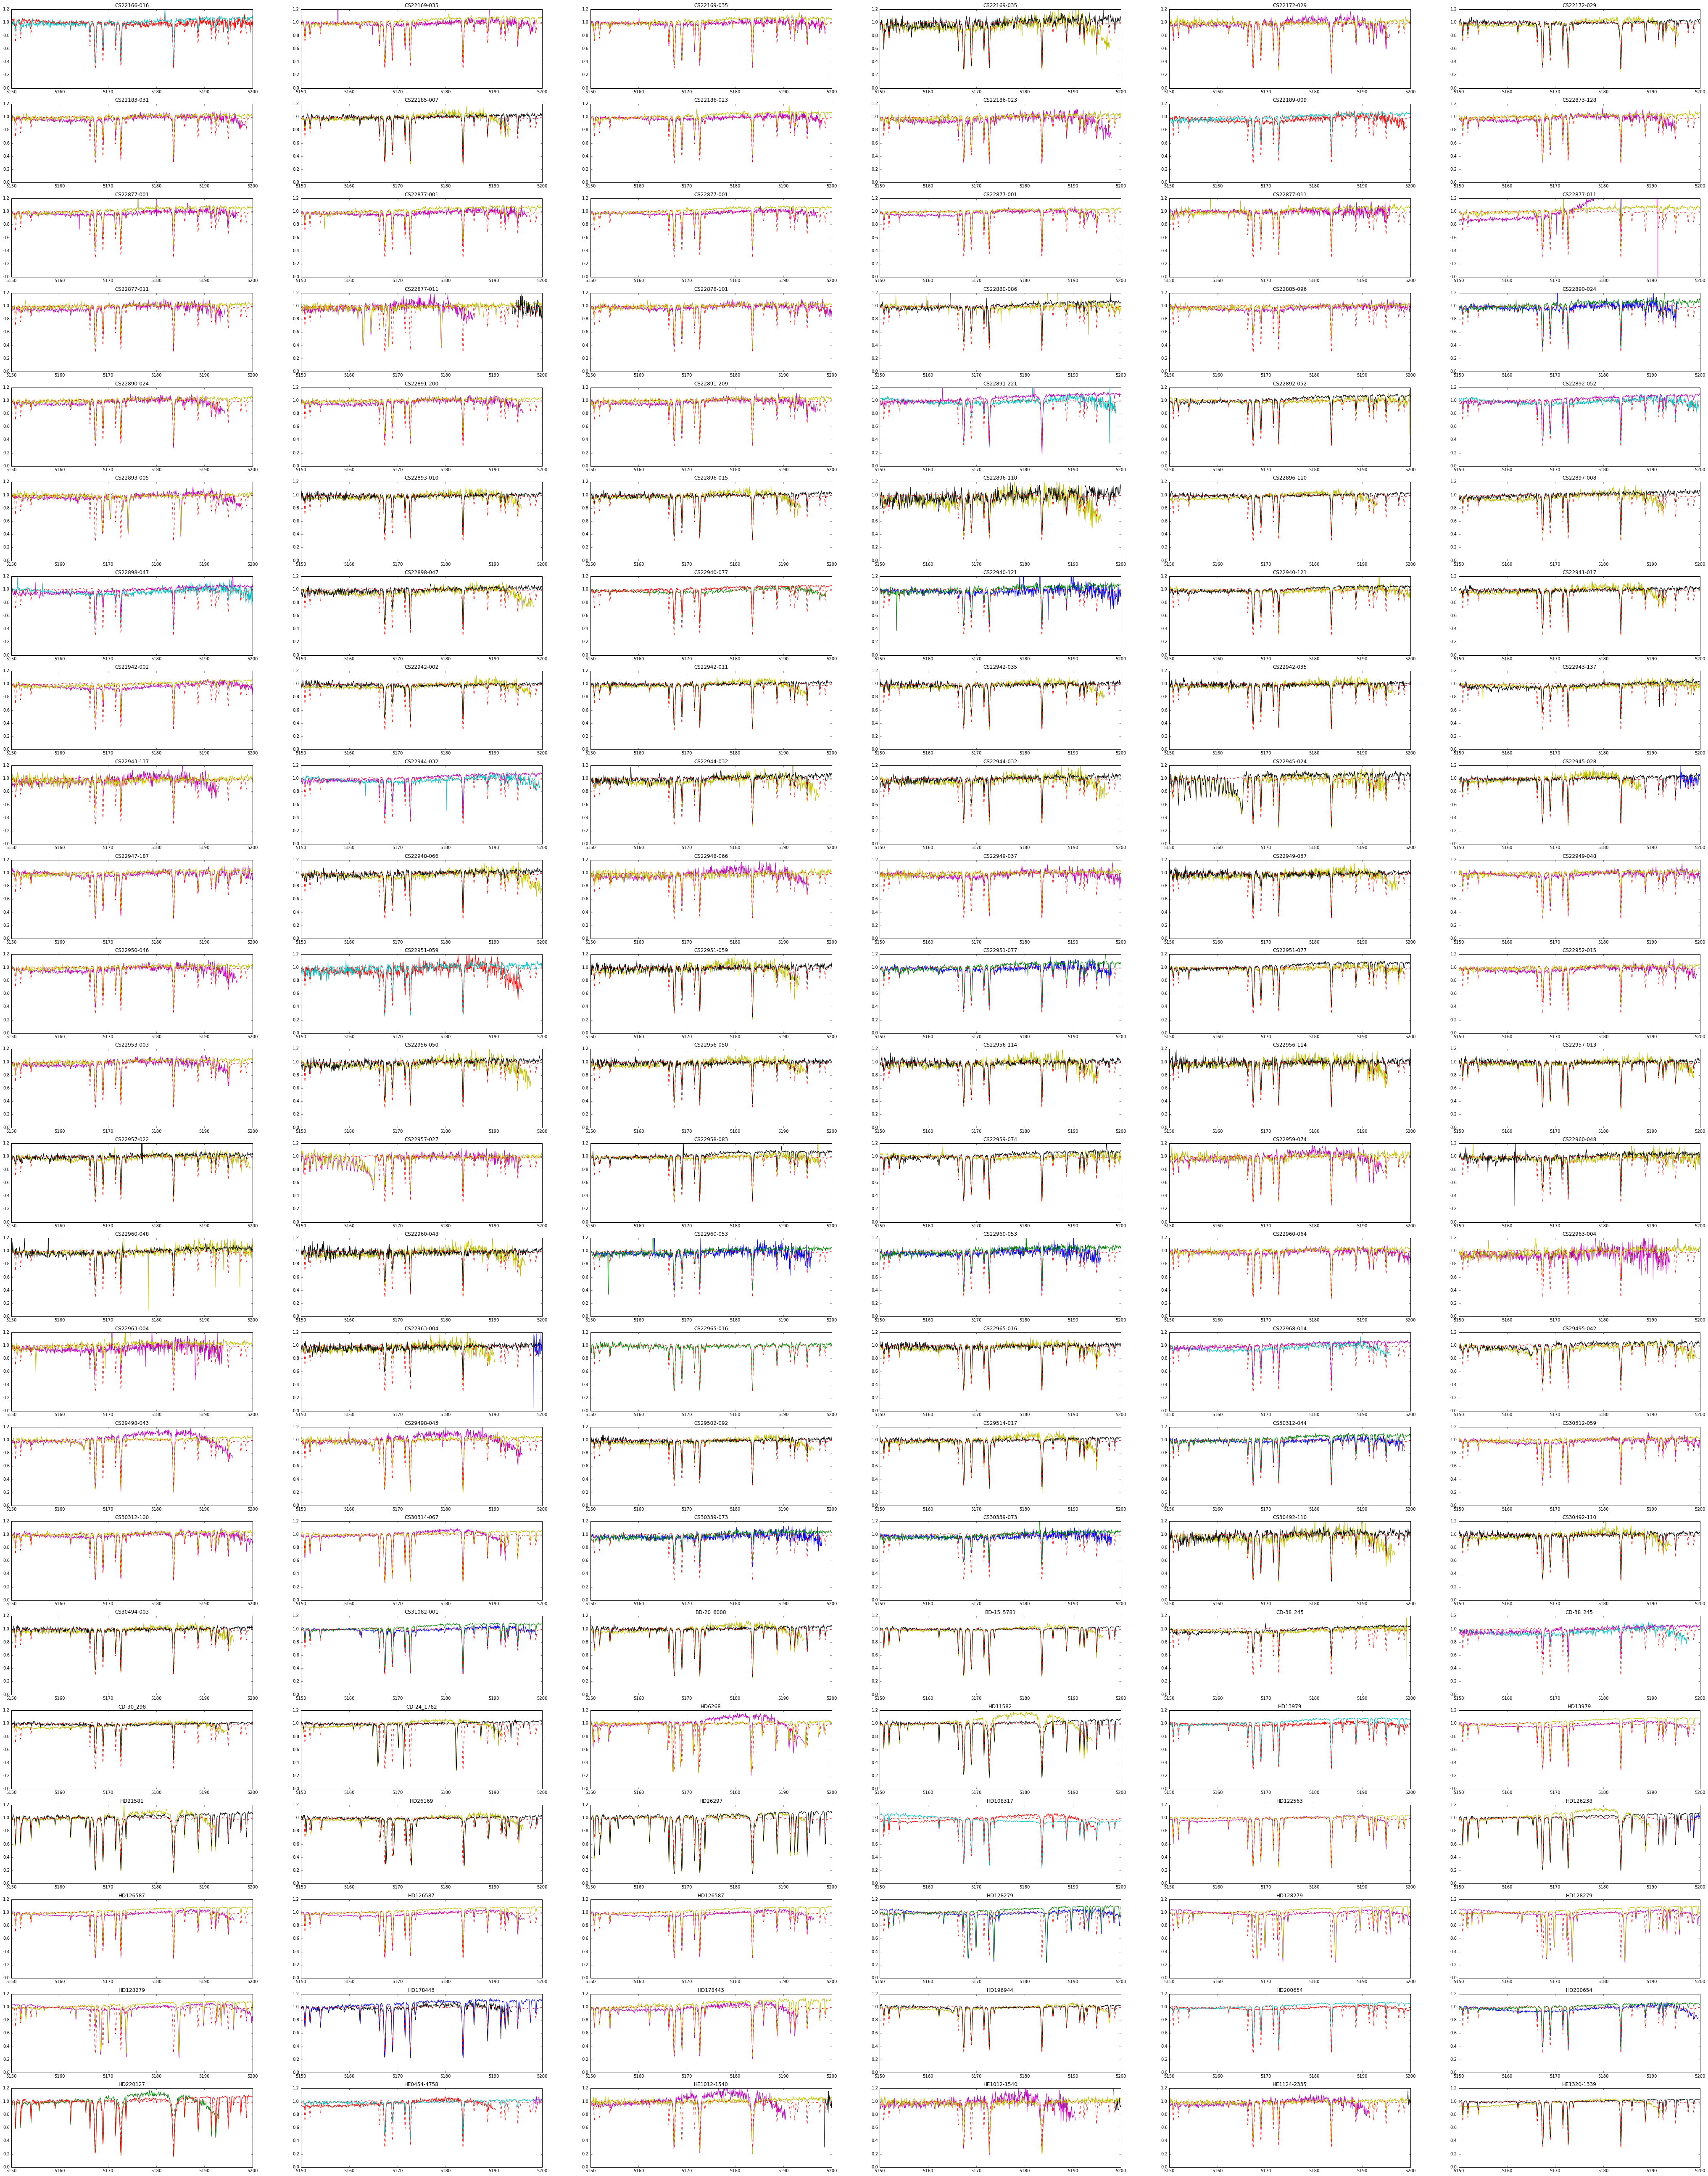

In [28]:
N = len(all_rv_spec)
fig, axes = plt.subplots(N/6, 6, figsize=(12*6,4*(N/6)))
for ax,orders,row in zip(axes.flat,all_rv_spec,tab):
    for order in orders:
        norm = order.fit_continuum(function="spline", full_output=False,
                                   order=fitorder, knot_spacing=50,
                                   low_sigma_clip=1.0, high_sigma_clip=0.2)
        ax.plot(norm.dispersion, norm.flux)
    ax.set_ylim(0,1.2)
    ax.set_xlim(5150,5200)
    ax.plot(template.dispersion, template.flux, 'r--')
    ax.set_title(row["Star"])
fig.savefig("all_rv_mgb.png", bbox_inches='tight')

# Put all spectra on the same wavelength grid
Do this order by order, then merge things together.

Orders should be identified by wlmin, wlmax, and dwl, mapped to an integer for which actual order.

The actual order numbers do not uniquely identify wavelength orders, as the plot below shows.

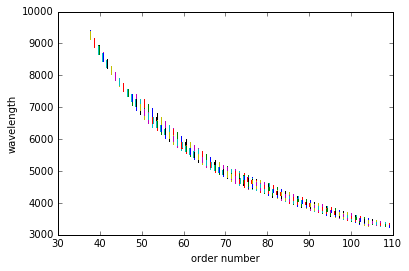

In [29]:
fig, ax = plt.subplots()
for row,orders in zip(tab, all_rv_spec):
    nums = map(int, row["order_nums"].split(','))
    for i, (num, order) in enumerate(zip(nums, orders)):
        ax.plot([num+i/100.,num+i/100.],[order.dispersion[0], order.dispersion[-1]])
ax.set_xlabel("order number")
ax.set_ylabel("wavelength")
fig.savefig("ordernumber.pdf", bbox_inches='tight')

This is mostly because a lot of the early observations were done with a blue setting that only goes up to ~7000A. This is responsible 34/138 spectra.

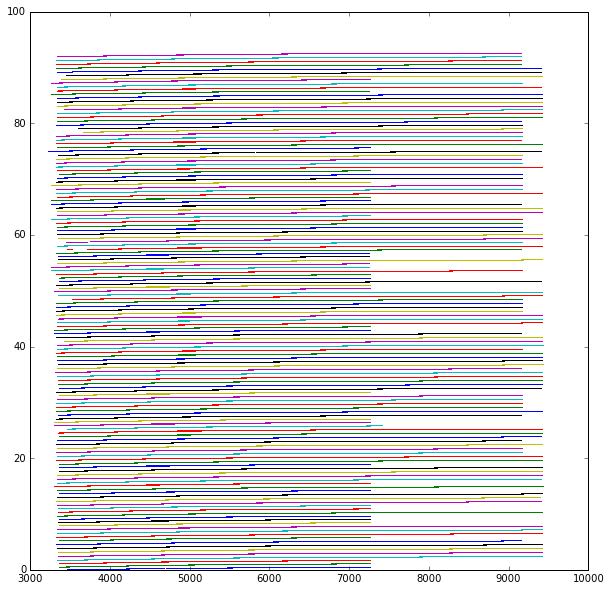

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
y = 0
colors = ['b','g','r','c','m','y','k']

for i,orders in enumerate(all_rv_spec):
    color = colors[i % len(colors)]
    for order in orders:
        ax.plot([order.dispersion[0], order.dispersion[-1]], [y,y], color)
        y += .01
fig.savefig("order_wavelengths.png", bbox_inches='tight')

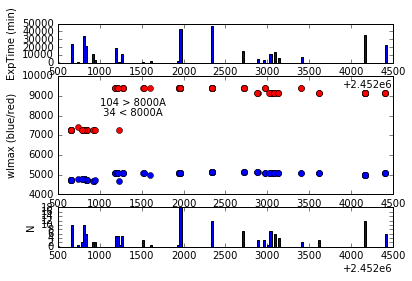

In [31]:
import matplotlib.gridspec as gridspec
offset=2452000
xlim = (500+offset,4500+offset)
bins = np.arange(500,4600,25)+offset
plt.figure()
gs = gridspec.GridSpec(3, 1,
                       #width_ratios=[3, 1],
                       height_ratios=[1, 3, 1])
ax = plt.subplot(gs[1, 0])
ax.plot(tab["MJD"], tab["blue_wlmax"], 'bo')
ax.plot(tab["MJD"], tab["red_wlmax"], 'ro')
ax.set_xlabel("MJD")
ax.set_ylabel("wlmax (blue/red)")
ax.set_xlim(xlim)
ax.text(1000+offset,8000, "{:3} < 8000A".format(np.sum(tab["red_wlmax"] < 8000)),ha='left')
ax.text(1000+offset,8500, "{:3} > 8000A".format(np.sum(tab["red_wlmax"] > 8000)),ha='left')

ax = plt.subplot(gs[0, 0])
ax.hist(tab["MJD"], bins=bins, weights=tab["ExpTime"])
ax.set_xlim(xlim)
ax.set_ylabel("ExpTime (min)")

ax = plt.subplot(gs[2, 0])
ax.hist(tab["MJD"], bins=bins)
ax.set_xlim(xlim)
ax.set_ylabel("N")

Cutting out the earlier spectra leaves us with ~100, and only one outlier on the blue side that is one order number off.

It probably is only correct to use the later spectra because the instrument setting will be different.

In [32]:
len(np.unique(tab[tab["red_wlmax"] > 8000]["Star"]))

82

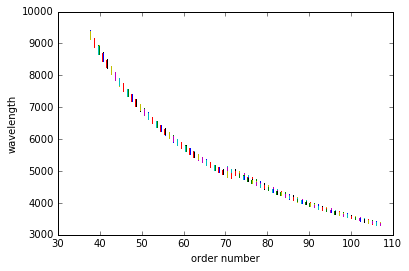

In [33]:
fig, ax = plt.subplots()
for row,orders in zip(tab, all_rv_spec):
    if row["red_wlmax"] < 8000: continue
    nums = map(int, row["order_nums"].split(','))
    for i, (num, order) in enumerate(zip(nums, orders)):
        ax.plot([num+i/100.,num+i/100.],[order.dispersion[0], order.dispersion[-1]])
ax.set_xlabel("order number")
ax.set_ylabel("wavelength")
fig.savefig("ordernumber_cut.pdf", bbox_inches='tight')

It's actually 2 outliers. I took these and hardcoded them to fix the order above.

In [34]:
wlstarts = []
wlends = []
for row,orders in zip(tab, all_rv_spec):
    if row["red_wlmax"] < 8000:
        wlstarts.append(np.nan)
        wlends.append(np.nan)
        continue
    order_nums = map(int, row["order_nums"].split(','))
    ix = order_nums.index(80)
    print "{:15} {:.1f} {:.1f}".format(row["Star"], orders[ix].dispersion[0], orders[ix].dispersion[-1])
    wlstarts.append(orders[ix].dispersion[0])
    wlends.append(orders[ix].dispersion[-1])
print np.nanmedian(wlstarts), np.nanmax(wlstarts)
print np.nanmedian(wlends), np.nanmax(wlends), np.sum(np.array(wlends) > 4520)
tab[np.array(wlends) > 4520].show_in_notebook()

CS22169-035     4405.6 4496.3
CS22172-029     4406.6 4497.2
CS22172-029     4406.6 4497.2
CS22183-031     4407.1 4497.6
CS22185-007     4409.0 4498.9
CS22186-023     4406.8 4497.3
CS22189-009     4407.2 4497.7
CS22873-128     4403.9 4494.3
CS22877-001     4404.2 4494.6
CS22877-011     4403.2 4493.6
CS22877-011     4395.4 4486.2
CS22878-101     4408.6 4499.1
CS22885-096     4410.6 4501.1
CS22890-024     4403.2 4493.7
CS22891-200     4404.8 4495.3
CS22891-209     4405.7 4496.1
CS22891-221     4462.4 4554.0
CS22892-052     4463.0 4554.7
CS22893-005     4405.6 4496.6
CS22893-010     4411.0 4500.9
CS22896-015     4409.1 4499.0
CS22896-110     4404.0 4494.6
CS22896-110     4401.6 4492.5
CS22897-008     4401.4 4492.0
CS22898-047     4463.7 4555.4
CS22898-047     4406.0 4496.7
CS22941-017     4408.6 4498.5
CS22942-002     4409.0 4499.6
CS22942-002     4412.7 4502.7
CS22942-011     4410.2 4500.1
CS22942-035     4404.5 4495.4
CS22942-035     4405.4 4496.1
CS22943-137     4403.0 4494.0
CS22944-03

In [35]:
for star in tab[tab["red_wlmax"] < 8000]:
    print star["Star"], np.sum(star["Star"]==tab["Star"])
print "Total unique stars", len(np.unique(tab["Star"]))
print "Total good unique stars", len(np.unique(tab[tab["red_wlmax"] > 8000]["Star"]))

CS22166-016 1
CS22169-035 3
CS22169-035 3
CS22186-023 2
CS22877-001 4
CS22877-001 4
CS22877-001 4
CS22877-011 4
CS22877-011 4
CS22880-086 1
CS22890-024 2
CS22892-052 2
CS22940-077 1
CS22940-121 2
CS22940-121 2
CS22943-137 2
CS22951-077 2
CS22951-077 2
CS22958-083 1
CS22959-074 2
CS22960-048 3
CS22960-048 3
CS22960-053 2
CS22960-053 2
CS22963-004 3
CS22963-004 3
CS30312-044 1
CS30339-073 2
CS30339-073 2
CS31082-001 1
CD-38_245 2
HD13979 2
HD178443 2
HD200654 2
Total unique stars 92
Total good unique stars 82


In [36]:
everything_orders = []
for _spec in all_rv_spec:
    everything_orders += _spec
everything_dispersion = specutils.spectrum.common_dispersion_map2(everything_orders)

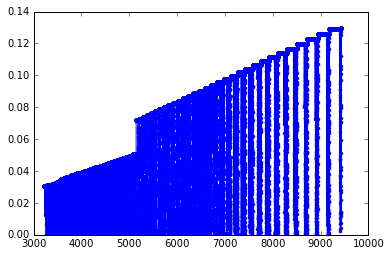

In [37]:
plt.figure()
#plt.plot(everything_dispersion,'.-')
plt.plot(everything_dispersion[1:],np.diff(everything_dispersion),'.-')

# Normalize

In [38]:
order = orders[18]

In [39]:
# norm, center, shape
finite = np.isfinite(order.flux)
x_ = order.dispersion[finite]
y_ = order.flux[finite]
w_ = order.ivar[finite]
p0 = (np.nanpercentile(y_, 95), np.median(x_), np.percentile(x_, 75) - np.percentile(x_, 25))
p,cov = optimize.curve_fit(lambda x, *p: p[0]*np.sinc((x-p[1])/p[2])**2,
                           x_, y_, p0)

_func = lambda x, *p: p[0]*np.sinc((x-p[1])/p[2])**2 * np.polyval(p[3:], x)
p0 = p[0], p[1], p[2], 0, 0, 0
p, cov = optimize.curve_fit(_func, x_, y_, p0, maxfev=100000)

In [26]:
?optimize.curve_fit

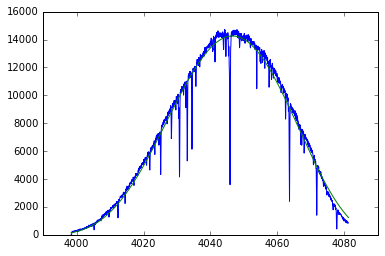

In [40]:
order = orders[18]
plt.figure()
plt.plot(order.dispersion, order.flux)
x = order.dispersion
#y = p[0]*np.sinc((x-p[1])/p[2])**2
y = _func(x, *p)
plt.plot(x,y)